In [4]:
from recsys_interface.data.interface import fetch_rgs_data, fetch_timeseries_data
# %load_ext autoreload
    # %autoreload 2

## NEST Patients

In [5]:
import pandas as pd

In [6]:
# PATIENT_LIST = [
#     204, 775, 787, 788, 946, 947, 953, 955, 957, 1123, 1169, 1170, 1171,
#     1172, 1173, 1222, 1551, 1553, 1555, 1556, 1861, 1983, 2110, 2195, 2843,
#     2913, 2925, 2926, 2937, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961,
#     2962, 2963, 3081, 3210, 3213, 3222, 3229, 3231, 3318, 3432
# ]

# Patients with identified clinical scales
PATIENT_LIST = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

In [7]:
patients_db = pd.read_csv('../../data/patient.csv', index_col=0)
patients_db = patients_db[["PATIENT_USER"]].loc[PATIENT_LIST]

## PIPELINE

---

INPUT:

- SessionBatch: pd.DataFrame = (sessions, session_info)

OUTPUT:

- WeeklyPrescriptionBatch

    - prescriptions: Dict[str, Dict[str, Any]] = (patient, protocol, prescription)

        prescription

        - day: List
        - score: int
        - factors: List
        - contributions: List
        - explanation: str
        
---

Dependencies

In [8]:
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np

### 1. Extraction

#### 1.1 Session data

---

INPUT: List = PATIENT_LIST

OUTPUT: pd.DataFrame = (sessions, patient_profile + session_info)

---

In [9]:
data_app = fetch_rgs_data(PATIENT_LIST, rgs_mode="app")
data_plus = fetch_rgs_data(PATIENT_LIST, rgs_mode="plus")
data = pd.concat([data_app, data_plus])

Database engine created successfully
Data successfully saved to rgs_interaction.csv
Database engine closed
Database engine created successfully
Data successfully saved to rgs_interaction.csv
Database engine closed


Data Validation 

In [10]:
expected_dtypes = {
    "PATIENT_ID": "Int64",
    "HOSPITAL_ID": "Int64",
    "PARETIC_SIDE": "string",
    "UPPER_EXTREMITY_TO_TRAIN": "string",
    "HAND_RAISING_CAPACITY": "string",
    "COGNITIVE_FUNCTION_LEVEL": "string",
    "HAS_HEMINEGLIGENCE": "Int64",
    "GENDER": "string",
    "SKIN_COLOR": "string",
    "AGE": "Int64",
    "VIDEOGAME_EXP": "Int64",
    "COMPUTER_EXP": "Int64",
    "COMMENTS": "string",
    "PTN_HEIGHT_CM": "Int64",
    "ARM_SIZE_CM": "Int64",
    "PRESCRIPTION_ID": "Int64",
    "SESSION_ID": "Int64",
    "PROTOCOL_ID": "Int64",
    "PRESCRIPTION_STARTING_DATE": "datetime64[ns]",
    "PRESCRIPTION_ENDING_DATE": "datetime64[ns]",
    "SESSION_DATE": "datetime64[ns]",
    "STARTING_HOUR": "Int64",
    "STARTING_TIME_CATEGORY": "string",
    "STATUS": "string",
    "PROTOCOL_TYPE": "string",
    "AR_MODE": "string",
    "WEEKDAY": "string",
    "REAL_SESSION_DURATION": "Int64",
    "PRESCRIBED_SESSION_DURATION": "Int64",
    "SESSION_DURATION": "Int64",
    "ADHERENCE": "float64",
    "TOTAL_SUCCESS": "Int64",
    "TOTAL_ERRORS": "Int64",
    "SCORE": "float64",
}
data = data.astype(expected_dtypes, errors="raise")

In [11]:
# Remove Na
data.dropna(subset=["PRESCRIPTION_ID","SESSION_DURATION"], inplace=True)

# Ensure STARTING_DATE and ENDING_DATE are datetime
data['SESSION_DATE'] = pd.to_datetime(data['SESSION_DATE'], errors='coerce')
data['PRESCRIPTION_STARTING_DATE'] = pd.to_datetime(data['PRESCRIPTION_STARTING_DATE'], errors='coerce')
data['PRESCRIPTION_ENDING_DATE'] = pd.to_datetime(data['PRESCRIPTION_ENDING_DATE'], errors='coerce')

data['SESSION_DATE'] = data['SESSION_DATE'].dt.date
data['PRESCRIPTION_STARTING_DATE'] = data['PRESCRIPTION_STARTING_DATE'].dt.date
data['PRESCRIPTION_ENDING_DATE'] = data['PRESCRIPTION_ENDING_DATE'].dt.date

# Weekday mapping dictionary
weekday_map = {
    "MONDAY": 0,
    "TUESDAY": 1,
    "WEDNESDAY": 2,
    "THURSDAY": 3,
    "FRIDAY": 4,
    "SATURDAY": 5,
    "SUNDAY": 6,
}

# Map the WEEKDAY column using the dictionary
data['WEEKDAY'] = data['WEEKDAY'].map(weekday_map)

#### 1.2 Augment with expected sessions

---

INPUT: pd.DataFrame = (sessions, patient_profile + session_info)

OUTPUT: pd.DataFrame = (sessions, patient_profile + session_info_expanded_prescribed_but_not_performed)

---

In [12]:
def generate_expected_sessions(start_date, end_date, target_weekday):
    """
    Generate all expected session dates between start_date and end_date
    for the given target weekday.
    """
    expected_dates = []
    today = date.today()
    
    # If Prescription not expired yet
    if end_date > today:
        end_date = today

    # Adjust the start date to the next target weekday
    if start_date.weekday() != target_weekday:
        days_until_target = int((target_weekday - start_date.weekday() + 7) % 7)
        start_date += timedelta(days=days_until_target)
    
    # Generate all expected session dates
    current_date = start_date
    while current_date <= end_date:
        expected_dates.append(current_date)
        current_date += timedelta(days=7)  # Move to the next week
    
    return expected_dates

In [13]:
def expand_expected_sessions(data):
    # For each unique prescription_id
    session_columns = [
    'SESSION_ID', 'STARTING_HOUR', 'STARTING_TIME_CATEGORY', 'REAL_SESSION_DURATION',
    'SESSION_DURATION', 'TOTAL_SUCCESS', 'TOTAL_ERRORS', 'SCORE'
    ]
    missing_sessions = []

    for _, group in data.groupby('PRESCRIPTION_ID'):
        # Get first row and
        prescription = group.iloc[0].copy()
        start = prescription.PRESCRIPTION_STARTING_DATE
        end = prescription.PRESCRIPTION_ENDING_DATE
        weekday = prescription.WEEKDAY
        expected_dates = generate_expected_sessions(start, end, weekday)        
        performed_dates = group.SESSION_DATE.dropna().unique()
        missing_dates = np.setdiff1d(expected_dates, performed_dates)

        # Create rows for missing sessions
        for missing_date in missing_dates:
            new_row = prescription.copy()
            new_row['SESSION_DATE'] = missing_date
            new_row['STATUS'] = 'NOT_PERFORMED'
            new_row['ADHERENCE'] = 0
            new_row[session_columns] = np.nan  # Set session-related columns to NaN
            missing_sessions.append(new_row)
        
    # Generate expected sessions
    df_missing = pd.DataFrame(missing_sessions)
    data = pd.concat([data, df_missing], ignore_index=True)
    data.sort_values(by=['PRESCRIPTION_ID', 'PROTOCOL_ID', 'SESSION_DATE'], inplace=True)
    
    return data

In [14]:
data_expanded = expand_expected_sessions(data)

/tmp/ipykernel_1717863/3321875871.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, df_missing], ignore_index=True)


#### 1.3 Timeseries data

---

INPUT: List = PATIENT_LIST

OUTPUT: pd.DataFrame = (sessions, time, DMs+PEs)

---


In [15]:
dms_app = fetch_timeseries_data(patients_ids=PATIENT_LIST, rgs_mode="app")
dms_plus = fetch_timeseries_data(patients_ids=PATIENT_LIST, rgs_mode="plus")
dms = pd.concat([dms_app, dms_plus])

Database engine created successfully
Data successfully saved to rgs_timeseries.csv
Database engine closed
Database engine created successfully
Data successfully saved to rgs_timeseries.csv
Database engine closed


Data Validation

In [16]:
dms["PARAMETER_VALUE"] = dms["PARAMETER_VALUE"].astype("float")
dms["PERFORMANCE_VALUE"] = dms["PERFORMANCE_VALUE"].astype("float")

DMs (same timepoint) mean collapse

In [17]:
timeseries = dms.groupby(
    ["PATIENT_ID", "PROTOCOL_ID", "GAME_MODE", "SECONDS_FROM_START"]
).agg({
    "PARAMETER_KEY": lambda x: list(set(x)),  # Unique list of parameter keys
    "PARAMETER_VALUE": lambda x: np.mean(x),  # Unique list of parameter values
    "PERFORMANCE_KEY": "first",  # Keeping first value (assuming it's the same within group)
    "PERFORMANCE_VALUE": "first"  # Keeping first value (assuming it's the same within group)
}).reset_index()

#### 1.4 Patient Profile - (Clinical Scales)

---

INPUT: excel = Clinical Scores of PATIENT_LIST

OUTPUT: pd.DataFrame = (patient, clinical subscales)

---

In [18]:
from pathlib import Path
nest_dir = Path("../../data/nest")
nest_data_pre = pd.read_excel(nest_dir / "NEST_clinical_score.xlsx", skiprows=1, sheet_name="T0", index_col=0)
nest_data_post = pd.read_excel(nest_dir / "NEST_clinical_score.xlsx", skiprows=1, sheet_name="T1", index_col=0)
column_names = ["BARTHEL", "ASH_PROXIMAL", "MA_DISTAL", "FATIGUE", "VAS", "FM_A", "FM_B", "FM_C", "FM_D", "FM_TOTAL", "ACT_AU", "ACT_QOM"]
nest_data_pre.columns = column_names
nest_data_post.columns = column_names

Fix Names to Match DB

In [19]:
def convert_pattern(input_string):
    # Convert to lowercase
    lowercase_string = input_string.lower()
    cleaned_string = lowercase_string.replace("_", "")
    result = f"user_{cleaned_string}"
    
    return result

def filter_str(input_string):
    if input_string.startswith("IT"):
        return convert_pattern(input_string)
    else:
        return input_string
    
nest_data_pre.index = nest_data_pre.index.map(filter_str)

Remove unidentified users

In [20]:
nest_data_pre = nest_data_pre.merge(patients_db, left_index=True, right_on="PATIENT_USER", how="inner").drop(columns="PATIENT_USER")

In [21]:
nest_data_pre.fillna(value=0, inplace=True)
nest_data_post.fillna(value=0, inplace=True)

In [22]:
nest_data_pre[["FM_A", "FM_B", "FM_C", "FM_D", "FM_TOTAL"]]

,FM_A,FM_B,FM_C,FM_D,FM_TOTAL
PATIENT_ID,,,,,
2110,31,5,13,4,53
775,33,9,14,5,61
788,31,8,8,6,53
787,28,5,7,2,42
1123,31,6,13,6,56
1169,9,0,2,1,12
1170,33,8,14,3,58
1171,26,4,7,2,39
1172,35,9,14,5,63


In [23]:
nest_data_pre.to_csv("../../data/clinical_scores.csv")

#### 1.5 Protocol Attributes

---

INPUT: csv = Protocol Matrix (protocol, implicit_features)

OUTPUT: pd.DataFrame = (protocol, implicit_features)

---

In [24]:
protocol_attributes = pd.read_csv("../../data/protocol_attributes.csv", index_col=0)

#### 1.6 Validation

Data consistency

In [25]:
try:
    assert dms.SESSION_ID.nunique() == data.SESSION_ID.nunique()
except AssertionError:
    print("[INFO]: RGS Sessions:", data.SESSION_ID.nunique(), "; Timeseries Sessions:", dms.SESSION_ID.nunique())
    print("[ERROR]: Mismatch in number of sessions in RGS data and Timeseries data")

try:
    assert dms.PROTOCOL_ID.nunique() == data.PROTOCOL_ID.nunique()
except AssertionError:
    print("[INFO]: RGS Protocols:", data.PROTOCOL_ID.nunique(), "; Timeseries Protocols:", dms.PROTOCOL_ID.nunique())
    print("[ERROR]: Mismatch in unique protocols seen in RGS data and Timeseries data")

[INFO]: RGS Sessions: 2765 ; Timeseries Sessions: 1625
[ERROR]: Mismatch in number of sessions in RGS data and Timeseries data
[INFO]: RGS Protocols: 18 ; Timeseries Protocols: 13
[ERROR]: Mismatch in unique protocols seen in RGS data and Timeseries data


### [TEST] Data Contracts

In [26]:
from typing import Optional
import msgspec

class Patient(msgspec.Struct):
    PATIENT_ID: int
    PARETIC_SIDE: str
    UPPER_EXTREMITY_TO_TRAIN: str
    HAND_RAISING_CAPACITY: str
    COGNITIVE_FUNCTION_LEVEL: str
    HAS_HEMINEGLIGENCE: int
    GENDER: str
    SKIN_COLOR: str
    AGE: Optional[int]
    VIDEOGAME_EXP: Optional[int]
    COMPUTER_EXP: Optional[int]
    COMMENTS: Optional[str]
    PTN_HEIGHT_CM: float
    ARM_SIZE_CM: float

class Session(msgspec.Struct):
    SESSION_ID: int
    PRESCRIPTION_ID: int
    PROTOCOL_ID: int
    PROTOCOL_TYPE: str
    PRESCRIPTION_STARTING_DATE: date
    PRESCRIPTION_ENDING_DATE: date
    SESSION_DATE: date
    WEEKDAY: float
    STATUS: str
    REAL_SESSION_DURATION: int
    PRESCRIBED_SESSION_DURATION: int
    SESSION_DURATION: int
    ADHERENCE: float
    TOTAL_SUCCESS: float
    TOTAL_ERRORS: float
    SCORE: float

In [27]:
data

,PATIENT_ID,HOSPITAL_ID,PARETIC_SIDE,UPPER_EXTREMITY_TO_TRAIN,HAND_RAISING_CAPACITY,COGNITIVE_FUNCTION_LEVEL,HAS_HEMINEGLIGENCE,GENDER,SKIN_COLOR,AGE,...,PROTOCOL_TYPE,AR_MODE,WEEKDAY,REAL_SESSION_DURATION,PRESCRIBED_SESSION_DURATION,SESSION_DURATION,ADHERENCE,TOTAL_SUCCESS,TOTAL_ERRORS,SCORE
0,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,Hands,NONE,4,492,300,300,1.000000,99,8,231.0
1,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,Hands,NONE,4,338,300,300,1.000000,64,17,88.0
2,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,AR,TABLE,4,280,240,240,1.000000,0,0,0.0
3,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,AR,TABLE,4,391,300,300,1.000000,1,2,1.0
4,775,40,LEFT,LEFT,LOW,MEDIUM,0,FEMALE,FDC3AD,88,...,Hands,NONE,0,472,300,300,1.000000,86,10,222.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,3432,41,RIGHT,RIGHT,HIGH,MEDIUM_HIGH,0,FEMALE,D09C80,55,...,Body,NONE,0,309,300,300,1.000000,21,0,21.0
223,3432,41,RIGHT,RIGHT,HIGH,MEDIUM_HIGH,0,FEMALE,D09C80,55,...,AR,NONE,0,336,300,300,1.000000,15,21,42.0
224,3432,41,RIGHT,RIGHT,HIGH,MEDIUM_HIGH,0,FEMALE,D09C80,55,...,AR,NONE,0,360,300,300,1.000000,0,0,220.0
225,3432,41,RIGHT,RIGHT,HIGH,MEDIUM_HIGH,0,FEMALE,D09C80,55,...,Hands,NONE,0,400,300,300,1.000000,81,187,81.0


In [28]:
patient_data = data.drop_duplicates(subset=["PATIENT_ID"])
rows = patient_data.to_dict(orient="records")
patients = [msgspec.convert(row, type=Patient) for row in rows]
# sessions = [msgspec.convert(row, type=Session) for row in rows]

In [29]:
patients

[Patient(PATIENT_ID=775, PARETIC_SIDE='LEFT', UPPER_EXTREMITY_TO_TRAIN='LEFT', HAND_RAISING_CAPACITY='LOW', COGNITIVE_FUNCTION_LEVEL='MEDIUM', HAS_HEMINEGLIGENCE=0, GENDER='FEMALE', SKIN_COLOR='FDC3AD', AGE=88, VIDEOGAME_EXP=0, COMPUTER_EXP=0, COMMENTS='', PTN_HEIGHT_CM=165.0, ARM_SIZE_CM=22.0),
 Patient(PATIENT_ID=787, PARETIC_SIDE='LEFT', UPPER_EXTREMITY_TO_TRAIN='LEFT', HAND_RAISING_CAPACITY='LOW', COGNITIVE_FUNCTION_LEVEL='LOW_MEDIUM', HAS_HEMINEGLIGENCE=0, GENDER='FEMALE', SKIN_COLOR='A37552', AGE=59, VIDEOGAME_EXP=0, COMPUTER_EXP=0, COMMENTS='', PTN_HEIGHT_CM=162.0, ARM_SIZE_CM=22.0),
 Patient(PATIENT_ID=788, PARETIC_SIDE='LEFT', UPPER_EXTREMITY_TO_TRAIN='LEFT', HAND_RAISING_CAPACITY='HIGH', COGNITIVE_FUNCTION_LEVEL='MEDIUM', HAS_HEMINEGLIGENCE=0, GENDER='MALE', SKIN_COLOR='6B4731', AGE=44, VIDEOGAME_EXP=0, COMPUTER_EXP=1, COMMENTS='', PTN_HEIGHT_CM=190.0, ARM_SIZE_CM=22.0),
 Patient(PATIENT_ID=1123, PARETIC_SIDE='LEFT', UPPER_EXTREMITY_TO_TRAIN='LEFT', HAND_RAISING_CAPACITY='MED

### 2. Metrics

#### 2.1 Adherence

---

INPUT: pd.DataFrame = (sessions, patient_profile + session_info)

OUTPUT: pd.DataFrame = (sessions, patient_profile + session_info + adherence_ewma)

---

In [30]:
# Compute Batch EWMA Adherence
alpha = 0.8
data_expanded['ADHERENCE_EWMA'] = (
    data_expanded.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['ADHERENCE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)

In [31]:
data_see = data_expanded[["PATIENT_ID", "PRESCRIPTION_ID", "SESSION_ID", "PROTOCOL_ID", "SESSION_DATE", "ADHERENCE", "ADHERENCE_EWMA"]]
data_see

,PATIENT_ID,PRESCRIPTION_ID,SESSION_ID,PROTOCOL_ID,SESSION_DATE,ADHERENCE,ADHERENCE_EWMA
7,775,78254,17629,214,2024-04-03,1.0,1.000000e+00
2765,775,78254,<NA>,214,2024-04-10,0.0,1.666667e-01
18,775,78254,19898,214,2024-04-17,1.0,8.387097e-01
2766,775,78254,<NA>,214,2024-04-24,0.0,1.666667e-01
39,775,78254,22876,214,2024-05-01,1.0,8.335467e-01
...,...,...,...,...,...,...,...
13612,2963,149206,<NA>,227,2025-01-31,0.0,1.029345e-05
13613,2963,149206,<NA>,227,2025-02-07,0.0,2.058690e-06
13614,2963,149206,<NA>,227,2025-02-14,0.0,4.117379e-07
13615,2963,149206,<NA>,227,2025-02-21,0.0,8.234759e-08


#### 2.2 Difficulty Modulators, Performance Estimators

---

INPUT: pd.DataFrame = (sessions, time, DMs+PEs)

OUTPUT: pd.DataFrame = (sessions, time, DMs+PEs + DMs_ewma+PEs_ewma)

---

In [32]:
# Compute Batch DMs PEs EWMA
alpha = 0.8
dms["PARAMETER_VALUE_EWMA"] = (
    dms.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['PARAMETER_VALUE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)
dms["PERFORMANCE_VALUE_EWMA"] = (
    dms.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['PERFORMANCE_VALUE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)
dms

,SESSION_ID,PATIENT_ID,PROTOCOL_ID,GAME_MODE,SECONDS_FROM_START,PARAMETER_KEY,PARAMETER_VALUE,PERFORMANCE_KEY,PERFORMANCE_VALUE,PARAMETER_VALUE_EWMA,PERFORMANCE_VALUE_EWMA
0,16798,775,224,STANDARD,21633,standard_dm_targetsNumber,0.1,standard_pe_ratioErrors,1.0,1.000000e-01,1.000000e+00
1,16798,775,224,STANDARD,33326,standard_dm_targetsNumber,0.2,standard_pe_ratioErrors,1.0,1.833333e-01,1.000000e+00
2,16798,775,224,STANDARD,47318,standard_dm_targetsNumber,0.3,standard_pe_ratioErrors,1.0,2.774194e-01,1.000000e+00
3,16798,775,224,STANDARD,66509,standard_dm_targetsNumber,0.4,standard_pe_ratioErrors,1.0,3.756410e-01,1.000000e+00
4,16798,775,224,STANDARD,90916,standard_dm_targetsNumber,0.5,standard_pe_ratioErrors,1.0,4.751601e-01,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
6436,105161,3432,223,STANDARD,61383,standard_dm_completionFactor,0.0,standard_pe_ratioErrors,0.0,6.392161e-40,7.205298e-40
6437,105161,3432,223,STANDARD,61383,standard_dm_circleSize,0.0,standard_pe_ratioErrors,0.0,1.278432e-40,1.441060e-40
6438,105161,3432,223,STANDARD,69176,standard_dm_targetsNumber,0.0,standard_pe_ratioErrors,0.0,2.556864e-41,2.882119e-41
6439,105161,3432,223,STANDARD,69176,standard_dm_completionFactor,0.0,standard_pe_ratioErrors,0.0,5.113729e-42,5.764239e-42


In [33]:
dms_see = dms[["PATIENT_ID", "SESSION_ID", "PROTOCOL_ID", "SECONDS_FROM_START", "PARAMETER_VALUE_EWMA", "PERFORMANCE_VALUE_EWMA"]]
dms_see

,PATIENT_ID,SESSION_ID,PROTOCOL_ID,SECONDS_FROM_START,PARAMETER_VALUE_EWMA,PERFORMANCE_VALUE_EWMA
0,775,16798,224,21633,1.000000e-01,1.000000e+00
1,775,16798,224,33326,1.833333e-01,1.000000e+00
2,775,16798,224,47318,2.774194e-01,1.000000e+00
3,775,16798,224,66509,3.756410e-01,1.000000e+00
4,775,16798,224,90916,4.751601e-01,1.000000e+00
...,...,...,...,...,...,...
6436,3432,105161,223,61383,6.392161e-40,7.205298e-40
6437,3432,105161,223,61383,1.278432e-40,1.441060e-40
6438,3432,105161,223,69176,2.556864e-41,2.882119e-41
6439,3432,105161,223,69176,5.113729e-42,5.764239e-42


#### 2.3 PPF Computation

##### 2.3.1 Mapping

---

INPUT: 
    
- Patient_Profile: pd.DataFrame = (patient, clinical subscales)
- Protocol_Attributes: pd.DataFrame = (protocol, implicit_features)
- Mapping_Dict: Dict[str, List] = {clinical_subscale: [implicit_features]}

OUTPUT: 

- Protocol_Attributes_Mapped: pd.DataFrame = (patient, clinical subscales)

---

In [34]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

Patients - Clinical Scores

- Format: (num_patients, num_features)

In [35]:
nest_data_pre.columns

Index(['BARTHEL', 'ASH_PROXIMAL', 'MA_DISTAL', 'FATIGUE', 'VAS', 'FM_A',
       'FM_B', 'FM_C', 'FM_D', 'FM_TOTAL', 'ACT_AU', 'ACT_QOM'],
      dtype='object')

Protocols - Attributes
- Format: (num_protocols, num_attributes)

In [36]:
protocol_attributes.columns

Index(['PROTOCOL_ID', 'DIFFICULTY_COGNITIVE', 'DIFFICULTY_MOTOR',
       'BODY_PART_FINGER', 'BODY_PART_WRIST', 'BODY_PART_ARM',
       'BODY_PART_SHOULDER', 'BODY_PART_TRUNK', 'REACHING', 'GRASPING',
       'PINCHING', 'PRONATION_SUPINATION', 'RANGE_OF_MOTION_H',
       'RANGE_OF_MOTION_V', 'PROCESSING_SPEED', 'ATTENTION', 'VISUAL_LANGUAGE',
       'VISUALSPATIAL_PROCESSING_AWARENESS_NEGLECT', 'COORDINATION',
       'MEMORY_WM', 'MEMORY_SEMANTIC', 'MATH', 'DAILY_LIVING_ACTIVITY',
       'SYMBOLIC_UNDERSTANDING', 'SEMANTIC_PROCESSING'],
      dtype='object')

Mapping - {clinical_scale: List[Attribute]}

In [37]:
def map_latent_to_clinical(protocol_attributes, mapping_dict, agg_func=np.mean):
    """We need to collapse the protocol feature space into the clinical feature space.
    """
    df_clinical = pd.DataFrame(index=protocol_attributes.index)

    # Collapse using agg_func the protocol latent attributes    
    for clinical_scale, features in mapping_dict.items():
        df_clinical[clinical_scale] = protocol_attributes[features].apply(agg_func, axis=1)

    df_clinical.index = protocol_attributes["PROTOCOL_ID"]

    return df_clinical

In [38]:
latent_to_clinical_mapping_nest = {
    # Functional Independence
    "BARTHEL": ["DAILY_LIVING_ACTIVITY"],  # Barthel Index measures independence in ADLs.

    # Motor Function (Spasticity & Strength)
    "ASH_PROXIMAL": ["BODY_PART_ARM", "BODY_PART_SHOULDER", "COORDINATION"],  # Ashworth scale for proximal limb spasticity.
    "MA_DISTAL": ["BODY_PART_FINGER", "BODY_PART_WRIST", "GRASPING", "PINCHING"],  # Motor Assessment for distal motor function.

    # Fatigue & Pain
    "FATIGUE": ["DIFFICULTY_COGNITIVE", "DIFFICULTY_MOTOR", "PROCESSING_SPEED", "ATTENTION"],  # Fatigue relates to cognitive/motor difficulty.
    "VAS": ["DIFFICULTY_COGNITIVE", "DIFFICULTY_MOTOR"],  # Visual Analog Scale (VAS) for perceived effort.

    # Fugl-Meyer Subscales (Motor Control & Coordination)
    "FM_A": ["BODY_PART_ARM", "BODY_PART_SHOULDER", "RANGE_OF_MOTION_H", "RANGE_OF_MOTION_V"],  # Upper Limb Motor
    "FM_B": ["BODY_PART_WRIST", "PRONATION_SUPINATION", "RANGE_OF_MOTION_H"],  # Wrist Motor
    "FM_C": ["BODY_PART_FINGER", "GRASPING", "PINCHING"],  # Hand Motor
    "FM_D": ["COORDINATION", "RANGE_OF_MOTION_H", "RANGE_OF_MOTION_V"],  # Coordination & Speed
    "FM_TOTAL": ["BODY_PART_ARM", "BODY_PART_WRIST", "BODY_PART_FINGER", "COORDINATION"],  # Full Upper Limb Score

    # Activity & Movement Quality
    "ACT_AU": ["BODY_PART_TRUNK"],  # Activity Autonomy linked to balance.
    "ACT_QOM": ["COORDINATION"],  # Quality of Movement related to balance & coordination.
}

##### 2.3.2 Computation

---

INPUT: 
    
- Patient_Profile: pd.DataFrame = (patient, clinical subscales)
- Protocol_Attributes_Mapped: pd.DataFrame = (patient, clinical subscales)

OUTPUT: 

- PPF_mat: pd.Dataframe = (patient, protocol)
- PPF_contributions: Any = (patient, protocol, contributions)

---

PPF Function

In [39]:
def cosine_similarity_matrix(df_left, df_right):
    """Compute PPF for each patient, protocol pair.

    Args:
        df_left (pd.DataFrame): Left matrix (patients, features)
        df_right (pd.DataFrame): Right matrix (protocols, features)
    """

    # Convert to numpy
    A = df_left.to_numpy()
    B = df_right.to_numpy()
    
    # Compute row-wise norms
    A_norms = np.linalg.norm(A, axis=1, keepdims=True)
    B_norms = np.linalg.norm(B, axis=1, keepdims=True)
    
    # Replace zero norms with a small value to avoid NaN (division by zero)
    A_norms[A_norms == 0] = 1e-10
    B_norms[B_norms == 0] = 1e-10

    # Normalize each row to unit vectors
    A_norm = A / A_norms
    B_norm = B / B_norms

    # Compute cosine similarity (dot product)
    similarity_matrix = np.dot(A_norm, B_norm.T)  # (rows of left) x (rows of right)

    return pd.DataFrame(similarity_matrix, index=df_left.index, columns=df_right.index)

In [40]:
def feature_contributions(df_A, df_B):
    # Convert to numpy
    A = df_A.to_numpy()
    B = df_B.to_numpy()

    # Compute row-wise norms
    A_norms = np.linalg.norm(A, axis=1, keepdims=True)
    B_norms = np.linalg.norm(B, axis=1, keepdims=True)
    
    # Replace zero norms with a small value to avoid NaN (division by zero)
    A_norms[A_norms == 0] = 1e-10
    B_norms[B_norms == 0] = 1e-10

    # Normalize each row to unit vectors
    A_norm = A / A_norms
    B_norm = B / B_norms

    # Compute feature contributions
    contributions = A_norm[:, np.newaxis, :] * B_norm[np.newaxis, :, :]

    return contributions

In [41]:
protocol_attributes_clinical = map_latent_to_clinical(protocol_attributes, latent_to_clinical_mapping_nest)

In [42]:
ppf = cosine_similarity_matrix(nest_data_pre, protocol_attributes_clinical)

In [43]:
contributions = feature_contributions(nest_data_pre, protocol_attributes_clinical)

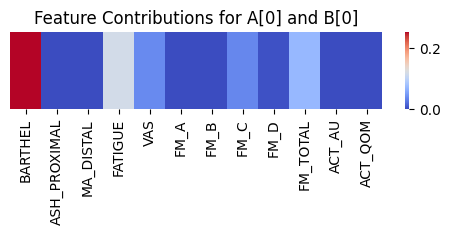

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plot contributions for the first row of A and first row of B
plt.figure(figsize=(6,1))
sns.heatmap(contributions[0, 1, :].reshape(1, -1), annot=False, cmap="coolwarm")
plt.xticks(ticks=np.arange(len(protocol_attributes_clinical.columns))+0.5, labels=protocol_attributes_clinical.columns, rotation=90)
plt.yticks([])
plt.title("Feature Contributions for A[0] and B[0]")
plt.show()

#### 2.4 Prognostics - Difficulty Match

Objective Function - (PPF + DMs + Adherence)

#### 2.5 Protocol Similarity

---

INPUT:

- Protocol_Attributes: pd.DataFrame = Protocol Matrix (protocol, implicit_features)

OUTPUT: 

- Similarity Matrix: pd.DataFrame = (protocol, protocol)

---

In [45]:
import gower

Similairity of Protocol Attributes

In [46]:
protocol_ids = protocol_attributes["PROTOCOL_ID"]
protocol_attributes.drop(columns="PROTOCOL_ID", inplace=True)
hot_encoded_cols = protocol_attributes.columns.str.startswith("BODY_PART")
weights = np.ones(len(protocol_attributes.columns))
weights[hot_encoded_cols] = weights[hot_encoded_cols] / hot_encoded_cols.sum()

In [47]:
protocol_attributes = protocol_attributes.astype(float)

In [48]:
gower_sim_matrix = gower.gower_matrix(protocol_attributes, weight=weights)
gower_sim_matrix = pd.DataFrame(1- gower_sim_matrix, index=protocol_ids, columns=protocol_ids)

In [49]:
# Plot heatmap
# plt.figure(figsize=(10, 10))
# sns.heatmap(gower_sim_matrix, annot=False, cmap="coolwarm")
# plt.title("Gower Similarity Matrix")
# plt.show()

### 3. Prescriptions

#### 3.1 Initialiasation

Sort PPF take top 10

In [50]:
num_protocols = 10
ranking = ppf.apply(lambda row: row.nlargest(num_protocols).index.tolist(), axis=1)
ranking_df = pd.DataFrame(ranking.tolist(), index=ppf.index)

Permutation

In [52]:
import numpy as np
import pandas as pd

def scheduling(ranking_df, days_per_week=7, prescriptions_per_day=5):
    """
    Generates a weekly schedule for each patient by distributing their top recommended protocols across the week.
    Ensures that:
    1. The same protocol is not scheduled twice in a single day.
    2. The total number of prescriptions is exactly `days_per_week * prescriptions_per_day`.
    
    Args:
    ranking_df (pd.DataFrame): DataFrame containing top recommended protocols for each patient.
    days_per_week (int): Number of days in the schedule (default: 7).
    prescriptions_per_day (int): Number of protocols per day (default: 5).
    
    Returns:
    dict: A dictionary where each key is a patient ID, and the value is another dictionary with protocol IDs as keys
          and lists of day indexes (1-based) as values.
    """
    total_prescriptions = days_per_week * prescriptions_per_day

    # Step 1: Expand protocol lists to ensure at least `total_prescriptions` recommendations per patient
    expanded_protocols = np.tile(ranking_df.to_numpy(), (1, -(-total_prescriptions // ranking_df.shape[1])))

    # Step 2: Shuffle each row independently
    for i in range(expanded_protocols.shape[0]):
        np.random.shuffle(expanded_protocols[i])

    # Step 3: Reshape to match (patients, days, prescriptions_per_day)
    reshaped_protocols = expanded_protocols[:, :total_prescriptions].reshape(ranking_df.shape[0], days_per_week, prescriptions_per_day)

    # Step 4: Create a dictionary for each patient
    schedule_dict = {}
    for patient_idx, patient_id in enumerate(ranking_df.index):
        patient_schedule = {}
        for day_idx in range(days_per_week):
            # Get the protocols for the current day
            day_protocols = reshaped_protocols[patient_idx, day_idx]
            # Ensure no duplicates in the day
            unique_protocols = list(dict.fromkeys(day_protocols))  # Preserves order while removing duplicates
            # If there are not enough unique protocols, reuse some (ensuring no duplicates in the day)
            while len(unique_protocols) < prescriptions_per_day:
                unique_protocols.append(np.random.choice(ranking_df.iloc[patient_idx]))
            # Assign the protocols to the day
            for protocol_id in unique_protocols[:prescriptions_per_day]:
                if protocol_id not in patient_schedule:
                    patient_schedule[protocol_id] = []
                patient_schedule[protocol_id].append(day_idx + 1)  # 1-based day index
        schedule_dict[patient_id] = patient_schedule

    return schedule_dict

In [53]:
weekly_prescriptions = scheduling(ranking_df)

In [54]:
weekly_prescriptions[2110]

{201: [1, 2, 4, 5],
 221: [1, 3, 7],
 224: [1, 1, 5],
 205: [1, 2, 3, 7],
 227: [2, 3, 7],
 208: [2, 5, 6, 7],
 222: [2, 4, 6],
 225: [3, 4, 5, 6],
 219: [3, 4, 5, 6],
 216: [4, 6, 7]}

#### 3.2 Update

Get this week scores

In [55]:
# Compute Batch DMs PEs EWMA
alpha = 0.8
data_expanded['ADHERENCE_EWMA'] = (
    data_expanded.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['ADHERENCE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)
dms["PARAMETER_VALUE_EWMA"] = (
    dms.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['PARAMETER_VALUE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)
dms["PERFORMANCE_VALUE_EWMA"] = (
    dms.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['PERFORMANCE_VALUE']
    .transform(lambda x: x.ewm(alpha=alpha, adjust=True).mean())
)

In [ ]:
# Aggregate dfs by last
dms_agg = dms.groupby(['PATIENT_ID', 'PROTOCOL_ID']).last().reset_index()
Reco
# Merge dataframes on PATIENT_ID and PROTOCOL_ID
data_all = data_agg[['PATIENT_ID', 'PROTOCOL_ID', 'ADHERENCE_EWMA']].merge(
    dms_agg[['PATIENT_ID', 'PROTOCOL_ID', 'PARAMETER_VALUE_EWMA', 'PERFORMANCE_VALUE_EWMA']],
    on=['PATIENT_ID', 'PROTOCOL_ID'],
    how='inner'
)

data_all.sort_values(by=['PATIENT_ID', 'PROTOCOL_ID'], inplace=True)

In [57]:
# To long format
ppf_stacked = ppf.stack().reset_index()
ppf_stacked.columns = ['PATIENT_ID', 'PROTOCOL_ID', 'PPF']
data_all = ppf_stacked.merge(data_all, left_on=['PATIENT_ID', 'PROTOCOL_ID'], right_on=['PATIENT_ID', 'PROTOCOL_ID'], how='left')
# Fill Non Played Protocols
data_all.fillna(value={"ADHERENCE_EWMA": 1, "PARAMETER_VALUE_EWMA": 0, "PERFORMANCE_VALUE_EWMA": 0}, inplace=True)

Compute Score

In [58]:
weights = [1, 1, 1]
# Compute the weighted combination
data_all['Score'] = (
    data_all['ADHERENCE_EWMA'] * weights[0] +
    data_all['PARAMETER_VALUE_EWMA'] * weights[1] +
    data_all['PPF'] * weights[2]
)

From last week prescriptions

In [59]:
# Group by PATIENT_ID
grouped = data_all.groupby('PATIENT_ID')

# Function to get protocol IDs above the 75th percentile
def get_protocols_above_75th_percentile(group):
    # Calculate the 75th percentile for the group
    percentile_75 = group['Score'].quantile(0.85)
    # Filter rows where Score is above the 75th percentile
    above_75 = group[group['Score'] > percentile_75]
    # Return the list of PROTOCOL_IDs
    return above_75['PROTOCOL_ID'].tolist()

# Apply the function to each group and create a new DataFrame
result = grouped.apply(get_protocols_above_75th_percentile).reset_index()
result.columns = ['PATIENT_ID', 'Protocols_Above_75th_Percentile']
result

/tmp/ipykernel_1717863/854148842.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(get_protocols_above_75th_percentile).reset_index()


,PATIENT_ID,Protocols_Above_75th_Percentile
0,775,"[208, 221, 225, 227, 216]"
1,787,"[208, 219, 206, 226, 217]"
2,788,"[221, 225, 227, 216]"
3,1123,"[208, 221, 225, 227, 216]"
4,1169,"[208, 225, 227, 216]"
5,1170,"[221, 225, 227, 216]"
6,1171,"[208, 201, 225, 227, 216]"
7,1172,"[208, 225, 227, 216]"
8,1173,"[225, 227, 216]"
9,1983,"[208, 225, 227, 216]"


In [60]:
def similar_protocol(protocol_id, A, num_protocols=5):
    """Get the most similar protocols to the given protocol_id from the set A.
    """
    # Get the similarity row for the given protocol_id
    similarity_row = A[protocol_id].drop(protocol_id)
    # Get the top num_protocols most similar protocols
    similar_protocols = similarity_row.nlargest(num_protocols).index.tolist()
    
    return dict(zip(similar_protocols, similarity_row[similar_protocols].values))

In [61]:
ps = similar_protocol(210, gower_sim_matrix, num_protocols=5)
similar = list(ps.keys())

Get the least used similar protocols

In [62]:
# Count protcol usage per patient
protocol_usage = data.groupby('PATIENT_ID')['PROTOCOL_ID'].value_counts().unstack(fill_value=0)

In [63]:
non_used_similar = sorted(
    similar,
    key=lambda x: protocol_usage.loc[775].get(x, 0),  # Default to 0 if protocol not found
    reverse=False  # Sort in descending order
)

Swap mechanism

In [64]:
weekly_prescriptions[2110]

{201: [1, 2, 4, 5],
 221: [1, 3, 7],
 224: [1, 1, 5],
 205: [1, 2, 3, 7],
 227: [2, 3, 7],
 208: [2, 5, 6, 7],
 222: [2, 4, 6],
 225: [3, 4, 5, 6],
 219: [3, 4, 5, 6],
 216: [4, 6, 7]}

In [65]:
list(weekly_prescriptions[2110].keys())

[201, 221, 224, 205, 227, 208, 222, 225, 219, 216]

In [66]:
# check protocols below 75 score for patient 2110
below_75 = [protocol for protocol in list(weekly_prescriptions[2110].keys()) if protocol not in result[result.PATIENT_ID == 2110].Protocols_Above_75th_Percentile.values[0]]

In [67]:
# find similar protocols to the below 75 protocols
similar_below_75 = {}
for protocol in below_75:
    similar_below_75[protocol] = similar_protocol(protocol, gower_sim_matrix, num_protocols=5)

In [68]:
# order the similar protocols by usage
similar_below_75_ordered = {}
for protocol, similar in similar_below_75.items():
    similar_below_75_ordered[protocol] = sorted(
        list(similar.keys()),
        key=lambda x: protocol_usage.loc[2110].get(x, 0),  # Default to 0 if protocol not found
        reverse=True  # Sort in descending order
    )
similar_below_75_ordered

{201: [224, 202, 222, 203, 221],
 224: [201, 202, 222, 203, 221],
 205: [227, 217, 233, 200, 225],
 208: [209, 219, 217, 204, 221],
 219: [209, 208, 206, 204, 221]}

In [69]:
def swap_protocols(patient_id, protocol_id, new_protocol_id, weekly_prescriptions):
    """Swap a protocol with a new protocol for a given patient.
        """
    # Get the patient's weekly schedule
    patient_schedule = weekly_prescriptions[patient_id]
    # Get the days where the protocol is scheduled
    days = patient_schedule[protocol_id]
    # Remove the protocol from the schedule
    patient_schedule.pop(protocol_id)
    # Add the new protocol to the schedule
    patient_schedule[new_protocol_id] = days

    return patient_schedule

In [70]:
# swap protocols below 75 with similar protocols with lower usage
for protocol, similar in similar_below_75_ordered.items():
    weekly_prescriptions = swap_protocols(2110, protocol, similar[0], weekly_prescriptions)
    break

### 4. DTO

In [71]:
import msgspec
from typing import Dict, List

In [72]:
class Prescription(msgspec.Struct):
    """Protocol planned for a weekly schedule"""
    prescription_id: str
    patient_id: str
    protocol_id: str
    start_date: Optional[date]
    end_date: Optional[date]
    weekday: str
    prescribed_duration: int

    # Prescription transparency
    scores: Dict[str, float] = msgspec.field(default_factory=dict)
    explanation: str = ""

class Day(msgspec.Struct):
    """A day composed of multiple prescriptions"""
    date: date
    prescriptions: List[Prescription] = msgspec.field(default_factory=list)

class Week(msgspec.Struct):
    """A week composed of multiple days"""
    start_date: date
    end_date: date
    days: List[Day] = msgspec.field(default_factory=list)

array([[0.26263085, 0.        , 0.        , 0.12025728, 0.03870349,
        0.        , 0.        , 0.02395931, 0.00368605, 0.07326018,
        0.        , 0.        ],
       [0.25130322, 0.        , 0.        , 0.11507042, 0.03703416,
        0.        , 0.        , 0.03438886, 0.00352706, 0.07010037,
        0.        , 0.        ],
       [0.36790573, 0.        , 0.        , 0.08423105, 0.02710884,
        0.12005345, 0.00645449, 0.01678166, 0.01032718, 0.05131317,
        0.        , 0.        ],
       [0.23644362, 0.        , 0.        , 0.09022191, 0.03484432,
        0.07715529, 0.00414813, 0.0215703 , 0.00995552, 0.06595533,
        0.        , 0.        ],
       [0.29916958, 0.        , 0.        , 0.06849409, 0.02204407,
        0.09762376, 0.01049718, 0.        , 0.01259661, 0.08345257,
        0.        , 0.        ],
       [0.29565395, 0.        , 0.        , 0.06768919, 0.02178503,
        0.09647655, 0.01037382, 0.01348597, 0.01244859, 0.08247189,
        0.        ,

# TODO

Add DTO

Add already computed Performance and DM to fetch_rgs_data query

Add explainability to PPF: Select sentences to populate